In [1]:
from ultralytics import YOLO
import tensorflow as tf
import cv2
import torch
import torchvision.models as models
import torchvision
import onnxruntime as ort
from onnxruntime.datasets import get_example
import numpy as np
from PIL import Image,ImageDraw
import io
from torchvision import transforms
from matplotlib import pyplot as plt
from torch import nn,optim,cuda,from_numpy,save
from ultralytics.yolo.utils.plotting import Annotator
import time
import os
import cv2
import warnings
from collections import namedtuple
from pathlib import Path
from typing import List, Optional, Tuple, Union
from numpy import ndarray
from pathlib import Path
from typing import List, Tuple, Union
from cuda import cudart
import tensorrt as trt
from io import BytesIO
import onnx
from ultralytics import YOLO
from TensorRT.models.common import PostDetect, optim
import onnxsim
import cv2
import numpy as np
import random
from TensorRT.models.utils import blob, det_postprocess, letterbox
from TensorRT.models.cudart_api import TRTEngine
from TensorRT.models import EngineBuilder

In [2]:
model = YOLO('yolov8n.pt')

## Train with WIDER_FACE dataset

In [5]:
results = model.train(data='data.yaml',epochs=10)

New https://pypi.org/project/ultralytics/8.0.115 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.114 🚀 Python-3.9.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

## Predict with PyTorch model


0: 512x640 19 faces, 82.3ms
Speed: 4.9ms preprocess, 82.3ms inference, 12.1ms postprocess per image at shape (1, 3, 512, 640)


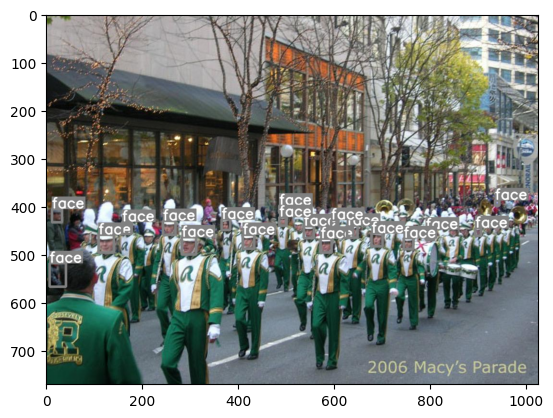

In [7]:
pt_model = YOLO('runs/detect/train3/weights/best.pt')
img = cv2.imread("yolo_data/images/test/0_Parade_marchingband_1_373.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = pt_model.predict(img)

for r in results:
    
    annotator = Annotator(img)
    
    boxes = r.boxes
    for box in boxes:
        
        b = box.xyxy[0] 
        c = box.cls
        annotator.box_label(b, pt_model.names[int(c)])
        
frame = annotator.result() 
plt.imshow(frame)
plt.imsave('result_pt.jpg',frame)

## PyTorch model convert to ONNX model

In [12]:
torch_model.export(format='onnx', dynamic=True)

Ultralytics YOLOv8.0.124 🚀 Python-3.9.16 torch-2.0.1+cu117 CPU

PyTorch: starting from runs/detect/train3/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: export success ✅ 0.5s, saved as runs/detect/train3/weights/best.onnx (11.5 MB)

Export complete (0.8s)
Results saved to /home/airi/Kamoliddin/YOLO_v8/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.onnx imgsz=640 data=data.yaml 
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'runs/detect/train3/weights/best.onnx'

## Predict with ONNX model

In [10]:
class_names = ['face']

# Create a list of colors for each class where each color is a tuple of 3 integer values
rng = np.random.default_rng(3)
colors = rng.uniform(0, 255, size=(len(class_names), 3))


def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes


def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou


def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def draw_detections(image, boxes, scores, class_ids, mask_alpha=0.3):
    mask_img = image.copy()
    det_img = image.copy()

    img_height, img_width = image.shape[:2]
    size = min([img_height, img_width]) * 0.0006
    text_thickness = int(min([img_height, img_width]) * 0.001)

    # Draw bounding boxes and labels of detections
    for box, score, class_id in zip(boxes, scores, class_ids):
        color = colors[class_id]

        x1, y1, x2, y2 = box.astype(int)

        # Draw rectangle
        cv2.rectangle(det_img, (x1, y1), (x2, y2), color, 2)

        # Draw fill rectangle in mask image
        cv2.rectangle(mask_img, (x1, y1), (x2, y2), color, -1)

        label = class_names[class_id]
        caption = f'{label} {int(score * 100)}%'
        (tw, th), _ = cv2.getTextSize(text=caption, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                      fontScale=size, thickness=text_thickness)
        th = int(th * 1.2)

        cv2.rectangle(det_img, (x1, y1),
                      (x1 + tw, y1 - th), color, -1)
        cv2.rectangle(mask_img, (x1, y1),
                      (x1 + tw, y1 - th), color, -1)
        cv2.putText(det_img, caption, (x1, y1),
                    cv2.FONT_HERSHEY_SIMPLEX, size, (255, 255, 255), text_thickness, cv2.LINE_AA)

        cv2.putText(mask_img, caption, (x1, y1),
                    cv2.FONT_HERSHEY_SIMPLEX, size, (255, 255, 255), text_thickness, cv2.LINE_AA)

    return cv2.addWeighted(mask_img, mask_alpha, det_img, 1 - mask_alpha, 0)


def draw_comparison(img1, img2, name1, name2, fontsize=2.6, text_thickness=3):
    (tw, th), _ = cv2.getTextSize(text=name1, fontFace=cv2.FONT_HERSHEY_DUPLEX,
                                  fontScale=fontsize, thickness=text_thickness)
    x1 = img1.shape[1] // 3
    y1 = th
    offset = th // 5
    cv2.rectangle(img1, (x1 - offset * 2, y1 + offset),
                  (x1 + tw + offset * 2, y1 - th - offset), (0, 115, 255), -1)
    cv2.putText(img1, name1,
                (x1, y1),
                cv2.FONT_HERSHEY_DUPLEX, fontsize,
                (255, 255, 255), text_thickness)


    (tw, th), _ = cv2.getTextSize(text=name2, fontFace=cv2.FONT_HERSHEY_DUPLEX,
                                  fontScale=fontsize, thickness=text_thickness)
    x1 = img2.shape[1] // 3
    y1 = th
    offset = th // 5
    cv2.rectangle(img2, (x1 - offset * 2, y1 + offset),
                  (x1 + tw + offset * 2, y1 - th - offset), (94, 23, 235), -1)

    cv2.putText(img2, name2,
                (x1, y1),
                cv2.FONT_HERSHEY_DUPLEX, fontsize,
                (255, 255, 255), text_thickness)

    combined_img = cv2.hconcat([img1, img2])
    if combined_img.shape[1] > 3840:
        combined_img = cv2.resize(combined_img, (3840, 2160))

    return combined_img


In [4]:
class YOLOv8:

    def __init__(self, path, conf_thres=0.7, iou_thres=0.5):
        self.conf_threshold = conf_thres
        self.iou_threshold = iou_thres

        # Initialize model
        self.initialize_model(path)

    def __call__(self, image):
        return self.detect_objects(image)

    def initialize_model(self, path):
        self.session = onnxruntime.InferenceSession(path,
                                                    providers=['CUDAExecutionProvider',
                                                               'CPUExecutionProvider'])
        # Get model info
        self.get_input_details()
        self.get_output_details()


    def detect_objects(self, image):
        input_tensor = self.prepare_input(image)

        # Perform inference on the image
        outputs = self.inference(input_tensor)

        self.boxes, self.scores, self.class_ids = self.process_output(outputs)

        return self.boxes, self.scores, self.class_ids

    def prepare_input(self, image):
        self.img_height, self.img_width = image.shape[:2]

        input_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize input image
        input_img = cv2.resize(input_img, (640, 640))

        # Scale input pixel values to 0 to 1
        input_img = input_img / 255.0
        input_img = input_img.transpose(2, 0, 1)
        input_tensor = input_img[np.newaxis, :, :, :].astype(np.float32)

        return input_tensor


    def inference(self, input_tensor):
        start = time.perf_counter()
        outputs = self.session.run(self.output_names, {self.input_names[0]: input_tensor})

        # print(f"Inference time: {(time.perf_counter() - start)*1000:.2f} ms")
        return outputs

    def process_output(self, output):
        predictions = np.squeeze(output[0]).T

        # Filter out object confidence scores below threshold
        scores = np.max(predictions[:, 4:], axis=1)
        predictions = predictions[scores > self.conf_threshold, :]
        scores = scores[scores > self.conf_threshold]

        if len(scores) == 0:
            return [], [], []

        # Get the class with the highest confidence
        class_ids = np.argmax(predictions[:, 4:], axis=1)

        # Get bounding boxes for each object
        boxes = self.extract_boxes(predictions)

        # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
        indices = nms(boxes, scores, self.iou_threshold)

        return boxes[indices], scores[indices], class_ids[indices]

    def extract_boxes(self, predictions):
        # Extract boxes from predictions
        boxes = predictions[:, :4]

        # Scale boxes to original image dimensions
        boxes = self.rescale_boxes(boxes)

        # Convert boxes to xyxy format
        boxes = xywh2xyxy(boxes)

        return boxes

    def rescale_boxes(self, boxes):

        # Rescale boxes to original image dimensions
        input_shape = np.array([640,640,640,640])
        boxes = np.divide(boxes, input_shape, dtype=np.float32)
        boxes = boxes * np.array([self.img_width, self.img_height, self.img_width, self.img_height])
        return boxes

    def draw_detections(self, image, draw_scores=True, mask_alpha=0.4):

        return draw_detections(image, self.boxes, self.scores,
                               self.class_ids, mask_alpha)

    def get_input_details(self):
        model_inputs = self.session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]

        self.input_shape = model_inputs[0].shape
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]

    def get_output_details(self):
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]

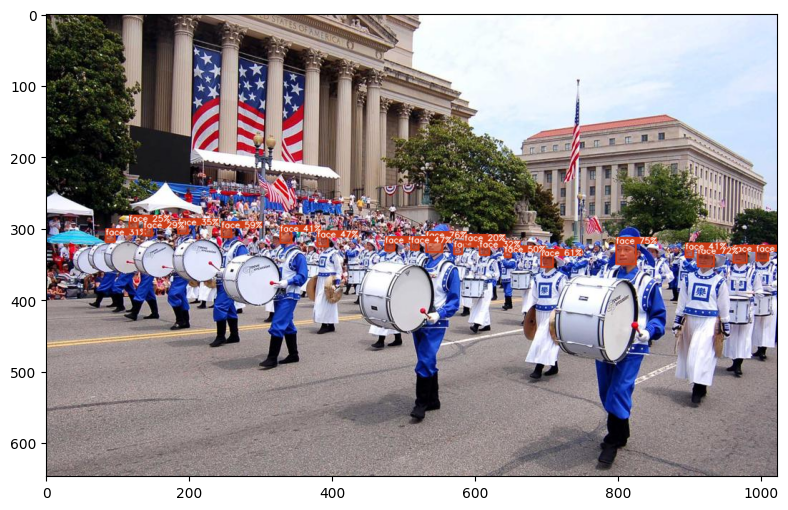

In [15]:
# Initialize yolov8 object detector
plt.figure(figsize=(10,6))
model_path = "runs/detect/train3/weights/best.onnx"
yolov8_detector = YOLOv8(model_path, conf_thres=0.2, iou_thres=0.3)

# Read image
img_url = "yolo_data/images/test/10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_836.jpg"
img = cv2.imread(img_url)

# Detect Objects
boxes, scores, class_ids = yolov8_detector(img)

# Draw detections
combined_img = yolov8_detector.draw_detections(img)
# cv2.namedWindow("Detected Objects", cv2.WINDOW_NORMAL)
# cv2.imshow("Detected Objects", combined_img)
combined_img = cv2.cvtColor(combined_img,cv2.COLOR_BGR2RGB)
plt.imshow(combined_img)

## PyTorch model convert to TFlite model

In [8]:
torch_model.export(format='tflite')

Ultralytics YOLOv8.0.114 🚀 Python-3.9.16 torch-2.0.1 CPU

PyTorch: starting from runs/detect/train3/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

TensorFlow SavedModel: starting export with tensorflow 2.12.0...

ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: simplifying with onnxsim 0.4.31...


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 1.8s, saved as runs/detect/train3/weights/best.onnx (11.6 MB)

TensorFlow SavedModel: running 'onnx2tf -i runs/detect/train3/weights/best.onnx -o runs/detect/train3/weights/best_saved_model -nuo --non_verbose'
TensorFlow SavedModel: export success ✅ 12.2s, saved as runs/detect/train3/weights/best_saved_model (29.2 MB)

TensorFlow Lite: starting export with tensorflow 2.12.0...
TensorFlow Lite: export success ✅ 0.0s, saved as runs/detect/train3/weights/best_saved_model/best_float32.tflite (11.6 MB)

Export complete (12.4s)
Results saved to /home/airi/Kamoliddin/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best_saved_model/best_float32.tflite imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train3/weights/best_saved_model/best_float32.tflite imgsz=640 data=data.yaml 
Visualize:       https://netron.app


'runs/detect/train3/weights/best_saved_model/best_float32.tflite'

## Predict with TFlite model

In [11]:
class LetterBox:
    """Resize image and padding for detection, instance segmentation, pose."""

    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, stride=32):
        """Initialize LetterBox object with specific parameters."""
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride

    def __call__(self, labels=None, image=None):
        """Return updated labels and image with added border."""
        if labels is None:
            labels = {}
        img = labels.get('img') if image is None else image
        shape = img.shape[:2]  # current shape [height, width]
        new_shape = labels.pop('rect_shape', self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        ratio = r, r  # width, height ratios
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:  # minimum rectangle
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:  # stretch
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        dw /= 2  # divide padding into 2 sides
        dh /= 2
        if labels.get('ratio_pad'):
            labels['ratio_pad'] = (labels['ratio_pad'], (dw, dh))  # for evaluation

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                 value=(114, 114, 114))  # add border

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels['img'] = img
            labels['resized_shape'] = new_shape
            return labels
        else:
            return img

    def _update_labels(self, labels, ratio, padw, padh):
        """Update labels."""
        labels['instances'].convert_bbox(format='xyxy')
        labels['instances'].denormalize(*labels['img'].shape[:2][::-1])
        labels['instances'].scale(*ratio)
        labels['instances'].add_padding(padw, padh)
        return labels

In [25]:
interpreter = tf.lite.Interpreter(model_path='runs/detect/train3/weights/best_saved_model/best_float32.tflite')
interpreter.allocate_tensors()

image_path = "yolo_data/images/test/0_Parade_Parade_0_1020.jpg"
imgsize = 640

im = [LetterBox(imgsize, auto=False, stride=32)(image=cv2.imread(image_path))]

im = np.stack(im)
print(im.shape)
im = im[..., ::-1].transpose((0, 1, 2, 3))  # BGR to RGB, BHWC to BCHW, (n, 3, h, w)
print(im.shape)

im = np.ascontiguousarray(im)  # contiguous
im = im.astype(np.float32)
im /= 255

# Allocate input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare the input tensor
input_data = im
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

(1, 640, 640, 3)
(1, 640, 640, 3)


In [26]:
nc = 0
conf_thres = 0.25

bs = output_data.shape[0]  # batch size
nc = nc or (output_data.shape[1] - 4)  # number of classes
nm = output_data.shape[1] - nc - 4
mi = 4 + nc  # mask start index
xc = np.amax(output_data[:, 4:mi], 1) > conf_thres  # candidates

multi_label=False
multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)

prediction = np.transpose(output_data, (0, -1, -2))

def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
    x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
    y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy
output = [np.zeros((0, 6 + nm))] * bs

max_nms=30000
agnostic=False
max_wh=7680
iou_thres = 0.45
max_det = 300

for xi, x in enumerate(prediction):  # image index, image inference
    x = x[xc[xi]]  # confidence

    if not x.shape[0]:
        continue

    # Detections matrix nx6 (xyxy, conf, cls)
    box = x[:, :4]
    cls = x[:, 4:4+nc]
    mask = x[:, 4+nc:4+nc+nm]

    conf = np.max(cls, axis=1, keepdims=True)
    j = np.argmax(cls, axis=1, keepdims=True)  

    # Concatenate the arrays along axis 1
    x = np.concatenate((box, conf, j.astype(float), mask), axis=1)

    # Reshape conf to a 1-dimensional array
    conf_flat = conf.flatten()

    # Filter the resulting array based on the condition conf_flat > conf_thres
    filtered_x = x[conf_flat > conf_thres]

    n = filtered_x.shape[0]  # number of boxes

    if not n:  # no boxes
        continue
    if n > max_nms:  # excess boxes
    # Sort x based on the 5th column in descending order
        sorted_indices = np.argsort(x[:, 4])[::-1]

    # Select the top max_nms rows based on the sorted indices
        x = x[sorted_indices[:max_nms]]

    c = x[:, 5:6] * (0 if agnostic else max_wh)
    boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores

    # Apply NMS using cv2.dnn.NMSBoxes function
    i = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.4, nms_threshold=iou_thres)
    i = i[:max_det]  # limit detections

    output[xi] = x[i]

In [27]:
def clip_boxes(boxes, shape):
    """
    It takes a list of bounding boxes and a shape (height, width) and clips the bounding boxes to the
    shape

    Args:
    boxes (torch.Tensor): the bounding boxes to clip
    shape (tuple): the shape of the image
    """
    boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    """
    Rescales bounding boxes (in the format of xyxy) from the shape of the image they were originally specified in
    (img1_shape) to the shape of a different image (img0_shape).

    Args:
    img1_shape (tuple): The shape of the image that the bounding boxes are for, in the format of (height, width).
    boxes (torch.Tensor): the bounding boxes of the objects in the image, in the format of (x1, y1, x2, y2)
    img0_shape (tuple): the shape of the target image, in the format of (height, width).
    ratio_pad (tuple): a tuple of (ratio, pad) for scaling the boxes. If not provided, the ratio and pad will be
                     calculated based on the size difference between the two images.

    Returns:
    boxes (torch.Tensor): The scaled bounding boxes, in the format of (x1, y1, x2, y2)
    """
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = round((img1_shape[1] - img0_shape[1] * gain) / 2 - 0.1), round(
            (img1_shape[0] - img0_shape[0] * gain) / 2 - 0.1)  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes

results = []

img = cv2.imread(image_path)

for i, pred in enumerate(output):
    pred[:, :4] = scale_boxes((640, 640), pred[:, :4], img.shape)
    results.append(pred)

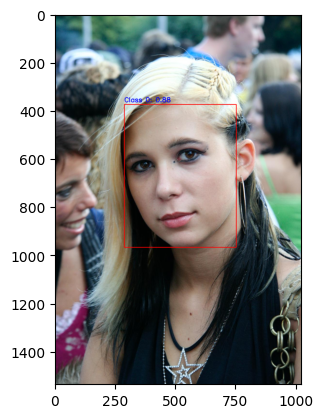

In [28]:
for detection in results:
    xmin, ymin, width, height, conf, class_id = detection[0]

    # Convert float coordinates to integers
    xmin = int(xmin)
    ymin = int(ymin)
    width = int(width)
    height = int(height)

    # Draw the rectangle on the image
    cv2.rectangle(img, (xmin, ymin), (width, height), (0, 0, 255), 2)

    # Add text label
    label = f"Class {int(class_id)}: {conf:.2f}"
    cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)

## PyTorch model convert to TensorRT model

In [11]:
torch_model.export(format='engine',device=0)

Ultralytics YOLOv8.0.114 🚀 Python-3.9.16 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)

PyTorch: starting from runs/detect/train3/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: simplifying with onnxsim 0.4.31...


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 0.8s, saved as runs/detect/train3/weights/best.onnx (11.6 MB)

TensorRT: starting export with TensorRT 8.6.0...
TensorRT: input "images" with shape(1, 3, 640, 640) DataType.FLOAT
TensorRT: output "output0" with shape(1, 5, 8400) DataType.FLOAT
TensorRT: building FP32 engine as runs/detect/train3/weights/best.engine


[06/12/2023-11:54:58] [TRT] [I] [MemUsageChange] Init CUDA: CPU +370, GPU +0, now: CPU 7168, GPU 22806 (MiB)
[06/12/2023-11:54:58] [TRT] [V] Trying to load shared library libnvinfer_builder_resource.so.8.6.1
[06/12/2023-11:54:58] [TRT] [V] Loaded shared library libnvinfer_builder_resource.so.8.6.1
[06/12/2023-11:55:02] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +1440, GPU +268, now: CPU 8685, GPU 23074 (MiB)
[06/12/2023-11:55:02] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[06/12/2023-11:55:02] [TRT] [I] ----------------------------------------------------------------
[06/12/2023-11:55:02] [TRT] [I] Input filename:   runs/detect/train3/weights/best.onnx
[06/12/2023-11:55:02] [TRT] [I] ONNX IR version:  0.0.8
[06/12/2023-11:55:02] [TRT] [I] Opset versi

TensorRT: export success ✅ 94.4s, saved as runs/detect/train3/weights/best.engine (18.5 MB)

Export complete (94.5s)
Results saved to /home/airi/Kamoliddin/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.engine imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.engine imgsz=640 data=data.yaml 
Visualize:       https://netron.app


[06/12/2023-11:56:31] [TRT] [V] Layer: /model.0/conv/Conv Host Persistent: 5296 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: PWN(PWN(/model.0/act/Sigmoid), /model.0/act/Mul) Host Persistent: 244 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: /model.1/conv/Conv Host Persistent: 5296 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: PWN(PWN(/model.1/act/Sigmoid), /model.1/act/Mul) Host Persistent: 244 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: /model.2/cv1/conv/Conv Host Persistent: 5296 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: PWN(PWN(/model.2/cv1/act/Sigmoid), /model.2/cv1/act/Mul) Host Persistent: 244 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: /model.2/m.0/cv1/conv/Conv Host Persistent: 5296 Device Persistent: 0 Scratch Memory: 0
[06/12/2023-11:56:31] [TRT] [V] Layer: PWN(PWN(/model.2/m.0/

'runs/detect/train3/weights/best.engine'

## Predict with TensorRT model

In [2]:
pt_model = 'runs/detect/train3/weights/best.pt'

PostDetect.conf_thres = 0.25
PostDetect.iou_thres = 0.65
PostDetect.topk = 100

b = 1
YOLOv8 = YOLO(pt_model)
model = YOLOv8.model.fuse().eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for m in model.modules():
    optim(m)
    m.to(device)
model.to(device)
fake_input = torch.randn((1,3,640,640)).to(device)
for _ in range(2):
    model(fake_input)
save_path = pt_model.replace('.pt', '.onnx')
with BytesIO() as f:
    torch.onnx.export(
        model,
        fake_input,
        f,
        opset_version=11,
        input_names=['images'],
        output_names=['num_dets', 'bboxes', 'scores', 'labels'])
    f.seek(0)
    onnx_model = onnx.load(f)
onnx.checker.check_model(onnx_model)
shapes = [b, 1, b, 100, 4, b, 100, b, 100]
for i in onnx_model.graph.output:
    for j in i.type.tensor_type.shape.dim:
        j.dim_param = str(shapes.pop(0))
try:
    onnx_model, check = onnxsim.simplify(onnx_model)
    assert check, 'assert check failed'
except Exception as e:
    print(f'Simplifier failure: {e}')
onnx.save(onnx_model, save_path)
print(f'ONNX export success, saved as {save_path}')

Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
[W shape_type_inference.cpp:1920] Warning: The shape inference of TRT::EfficientNMS_TRT type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W shape_type_inference.cpp:1920] Warning: The shape inference of TRT::EfficientNMS_TRT type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W shape_type_inference.cpp:1920] Warning: The shape inference of TRT::EfficientNMS_TRT type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W shape_type_inference.cpp:1920] Warning: The shape inference of TRT::EfficientNMS_TRT type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it i

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 4 WARNING 0 ERROR ========================
4 WARNING were not printed due to the log level.

ONNX export success, saved as runs/detect/train3/weights/best.onnx


In [3]:
onnx_model = 'runs/detect/train3/weights/best.onnx'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

builder = EngineBuilder(onnx_model, device)
builder.seg = True
builder.build(fp16=True,
              input_shape=[1, 3, 640, 640],
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

[07/28/2023-11:26:18] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[07/28/2023-11:26:18] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[07/28/2023-11:26:18] [TRT] [W] builtin_op_importers.cpp:5221: Attribute class_agnostic not found in plugin node! Ensure that the plugin creator has a default value defined or the engine may fail to build.
[07/28/2023-11:26:18] [TRT] [W] input "images" with shape: (1, 3, 640, 640) dtype: DataType.FLOAT
[07/28/2023-11:26:18] [TRT] [W] output "num_dets" with shape: (1, 1) dtype: DataType.INT32
[07/28/2023-11:26:18] [TRT] [W] output "bboxes" with shape: (1, 100, 4) dtype: DataType.FLOAT
[07/28/2023-11:26:18] [TRT] [W] output "scores" with shape: (1, 100) dtype: DataType.FLOAT
[07/28/2023-11:26:18] [TRT] [W] output "labels" with shape: (1, 100) dtype: DataType.INT32
[07/28/2023-11:26:18]

[07/28/2023-11:32:29] [TRT] [W] TensorRT was linked against cuDNN 8.9.0 but loaded cuDNN 8.5.0
[07/28/2023-11:32:29] [TRT] [W] TensorRT was linked against cuDNN 8.9.0 but loaded cuDNN 8.5.0


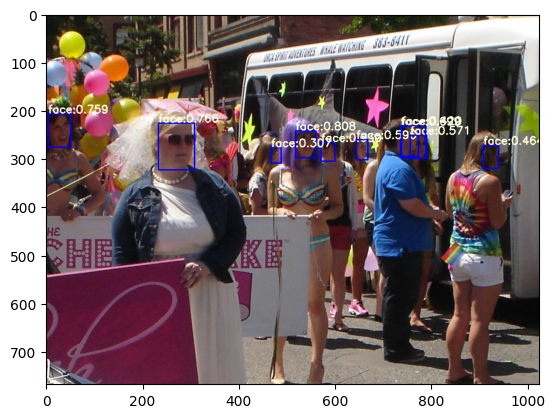

In [7]:
engine_path = 'runs/detect/train3/weights/best.engine'
Engine = TRTEngine(engine_path)
H, W = Engine.inp_info[0].shape[-2:]


frame = cv2.imread('yolo_data/images/test/0_Parade_Parade_0_141.jpg')
draw = frame.copy()
bgr, ratio, dwdh = letterbox(frame, (W, H))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
tensor = blob(rgb, return_seg=False)
dwdh = np.array(dwdh * 2, dtype=np.float32)
tensor = np.ascontiguousarray(tensor)
# inference
data = Engine(tensor)
bboxes, scores, labels = det_postprocess(data)
bboxes -= dwdh
bboxes /= ratio

for (bbox, score, label) in zip(bboxes, scores, labels):
    bbox = bbox.round().astype(np.int32).tolist()
    cls_id = int(label)
    cls = 'face'
    color = (255, 0, 0)
    cv2.rectangle(draw, bbox[:2], bbox[2:], color, 2)
    cv2.putText(draw, f'{cls}:{score:.3f}', (bbox[0], bbox[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)
draw = cv2.cvtColor(draw,cv2.COLOR_BGR2RGB)
plt.imshow(draw)